# Calibration (Creating the Scorecard)

**Week 6** - BayesRisk Project

**Author:** Desmond Momanyi Mariita

**Date:** 2026-01-11

---

## 1. Objectives

Convert the model's raw probability (e.g., "Probability of Default = 0.12") into a consumer-friendly score (e.g., "720").

The Standard FICO Scaling Formula:
- Base Score: 600
- Odds: 50:1 (at 600 points)
- PDO (Points to Double Odds): 20 (Every 20 points, the risk halves).

## 2. Implementation

##### 2.1: Load the Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import statsmodels.api as sm

# Define paths (must match the save paths)
model_path = '../../data/processed/logit_model.pkl'
xtest_path = '../../data/processed/X_test.pkl'
ytest_path = '../../data/processed/y_test.pkl'

# 1. Load the Model
with open(model_path, 'rb') as f:
    logit_model = pickle.load(f)

# 2. Load the Data
X_test = pd.read_pickle(xtest_path)
y_test = pd.read_pickle(ytest_path)

print("✅ Model and Test Data successfully loaded.")
print(f"Model Summary: {logit_model.summary().tables[0]}") # Quick verification

✅ Model and Test Data successfully loaded.
Model Summary:                            Logit Regression Results                           
Dep. Variable:                 target   No. Observations:              1314375
Model:                          Logit   Df Residuals:                  1314369
Method:                           MLE   Df Model:                            5
Date:                Mon, 12 Jan 2026   Pseudo R-squ.:                 0.04578
Time:                        22:45:46   Log-Likelihood:            -6.3162e+05
converged:                       True   LL-Null:                   -6.6193e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000


##### 2.2 Calibration Logic
Now that the model is loaded, we apply the scaling logic to convert probabilities into a 300-850 credit score.

In [2]:
def calibrate_score(prob_default: pd.Series, base_score: int = 600, pdo: int = 20, odds_base: int = 50) -> pd.Series:
    """
    Converts Probability of Default (PD) into a credit score using the standard 
    Scorecard scaling formula.

    Formula:
    Score = Offset + Factor * ln(Odds)
    where:
    - Factor = PDO / ln(2)
    - Offset = BaseScore - (Factor * ln(OddsBase))
    - Odds = (1 - PD) / PD  (Good to Bad Ratio)

    Args:
        prob_default (pd.Series): Series of probabilities (0 to 1) from the model.
        base_score (int): The score at the reference odds (default 600).
        pdo (int): Points to Double Odds (default 20).
        odds_base (int): The target odds at the base score (default 50:1).

    Returns:
        pd.Series: Integer scores (typically 300-850).
    """
    # 1. Calculate Calibration Constants
    factor = pdo / np.log(2)
    offset = base_score - (factor * np.log(odds_base))
    
    # 2. Calculate Odds (Good : Bad)
    # Add epsilon to prevent division by zero or log(0)
    epsilon = 1e-10
    prob_default = prob_default.clip(lower=epsilon, upper=1-epsilon)
    odds = (1 - prob_default) / prob_default
    
    # 3. Calculate Score
    score = offset + (factor * np.log(odds))
    
    # 4. Round to integer
    return score.astype(int)

# --- EXECUTION ---

# 1. Get Probabilities from the loaded Test Set
# model.predict returns the Probability of Default (Target=1)
y_pred_prob = logit_model.predict(X_test)

# 2. Generate Scores
scores = calibrate_score(y_pred_prob)

# 3. Create a summary dataframe
df_scored = pd.DataFrame({
    'Probability_Default': y_pred_prob,
    'Credit_Score': scores,
    'Actual_Status': y_test  # 0=Good, 1=Bad
})

display(df_scored.head())

,Probability_Default,Credit_Score,Actual_Status
534638,0.187538,529,0
1524761,0.227104,522,0
2462603,0.101348,550,1
2678249,0.137805,540,0
1714235,0.160851,534,0


##### 2.3 Visualize the Score Distribution
We need to verify that "Good" customers actually have higher scores than "Bad" customers.

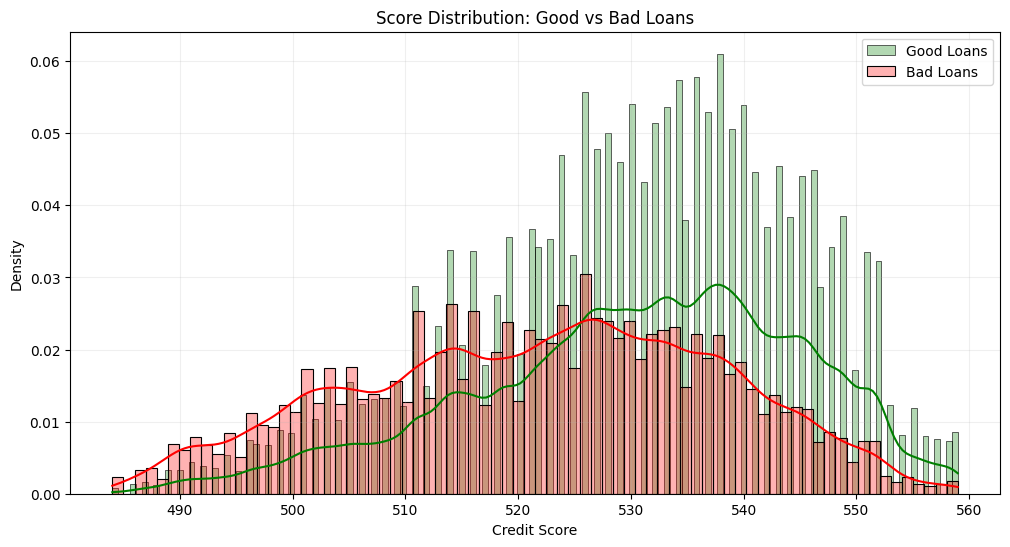

In [8]:
def plot_score_distribution(df: pd.DataFrame):
    """
    Visualizes the separation (discriminatory power) between Good and Bad loans 
    across the calibrated Credit Score range.

    The plot displays two overlapping histograms/KDEs:
    - Green: Distribution of scores for Non-Defaulters (Target=0).
    - Red: Distribution of scores for Defaulters (Target=1).
    
    A strong model will show a distinct separation where the Green curve is 
    shifted significantly to the right of the Red curve.

    Args:
        df (pd.DataFrame): A dataframe containing the scoring results. Must include:
                           - 'Credit_Score': The calibrated integer score.
                           - 'Actual_Status': The binary target (0=Good, 1=Bad).

    Returns:
        None: Displays a matplotlib/seaborn figure.
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot Good Loans (Green)
    sns.histplot(
        df[df['Actual_Status'] == 0]['Credit_Score'], 
        color='green', label='Good Loans', kde=True, stat="density", alpha=0.3,
        ax=ax
    )
    
    # Plot Bad Loans (Red)
    sns.histplot(
        df[df['Actual_Status'] == 1]['Credit_Score'], 
        color='red', label='Bad Loans', kde=True, stat="density", alpha=0.3,
        ax=ax
    )
    
    ax.set_title('Score Distribution: Good vs Bad Loans')
    ax.set_xlabel('Credit Score')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.2)
    plt.show()
    
plot_score_distribution(df_scored)

##### 2.4 Business Strategy (The Cut-off Analysis)
Now that we have the scores, the final piece of the puzzle is determining the Cut-off Score.

- Question: "At what score do we automatically reject an applicant?"

- Trade-off: If we set the cut-off at 510, we avoid many Bad loans (Red), but we also reject some Good loans (Green).

Goal: Translate the model's math into a business rule.
- The Trade-off: We want to maximize approvals (Volume) while keeping the Bad Rate below our risk appetite (e.g., 5%).
- The Tool: A "Strategy Table" that simulates the portfolio performance at every possible cut-off score.

##### 2.4.1: The Strategy Table
This function calculates the cumulative risk. It answers: "If I reject everyone below Score X, what will my portfolio look like?"

In [12]:
def calculate_strategy_table(df: pd.DataFrame, target_col: str = 'Actual_Status', score_col: str = 'Credit_Score') -> pd.DataFrame:
    """
    Generates a 'Strategy Table' to determine the optimal cut-off score.
    
    This function calculates cumulative metrics assuming a 'Accept All Above X' strategy.
    It sorts scores from High to Low and calculates the expanding approval and default rates.

    Args:
        df (pd.DataFrame): Dataframe containing 'Credit_Score' and 'Actual_Status'.
        target_col (str): The binary target column name (1=Bad).
        score_col (str): The credit score column name.

    Returns:
        pd.DataFrame: A table indexed by Credit Score with columns:
                      - 'Approval_Rate': % of applicants accepted if cut-off is here.
                      - 'Bad_Rate': % of accepted applicants who will default.
    """
    # 1. Group by Score and calculate localized stats
    # We count total apps and total bads at each specific score integer
    grouped = df.groupby(score_col)[target_col].agg(['count', 'sum']).sort_index(ascending=False)
    grouped.columns = ['n_apps', 'n_bads']
    
    # 2. Calculate Cumulative Stats (Simulating "Accept all above this score")
    grouped['cum_apps'] = grouped['n_apps'].cumsum()
    grouped['cum_bads'] = grouped['n_bads'].cumsum()
    
    # 3. Calculate Rates
    total_apps = df.shape[0]
    
    # Approval Rate: What % of the total population is in this bucket or higher?
    grouped['Approval_Rate'] = grouped['cum_apps'] / total_apps
    
    # Bad Rate: Of the people we accepted (cum_apps), how many went bad?
    grouped['Bad_Rate'] = grouped['cum_bads'] / grouped['cum_apps']
    
    # 4. Filter for readability (e.g., show every 10th score or just return all)
    # We return all, but you can inspect specific rows later
    return grouped[['Approval_Rate', 'Bad_Rate']]

# Execute
strategy_df = calculate_strategy_table(df_scored)

# Filter for scores between 490 and 550 to see the active trade-off zone
view_mask = (strategy_df.index >= 490) & (strategy_df.index <= 550)
subset = strategy_df[view_mask]

# Display every 5th row to make it readable
display(subset.iloc[::5])

,Approval_Rate,Bad_Rate
Credit_Score,,
550,0.067216,0.091857
545,0.155790,0.100174
540,0.260749,0.112703
535,0.387808,0.124356
530,0.517802,0.135796
525,0.638027,0.147074
520,0.730506,0.156939
515,0.806106,0.166241
510,0.872492,0.175884


##### 2.4.2: Visualizing the Trade-off
This plot is the "Executive Summary" of our entire project. It tells management exactly where the "Sweet Spot" is.

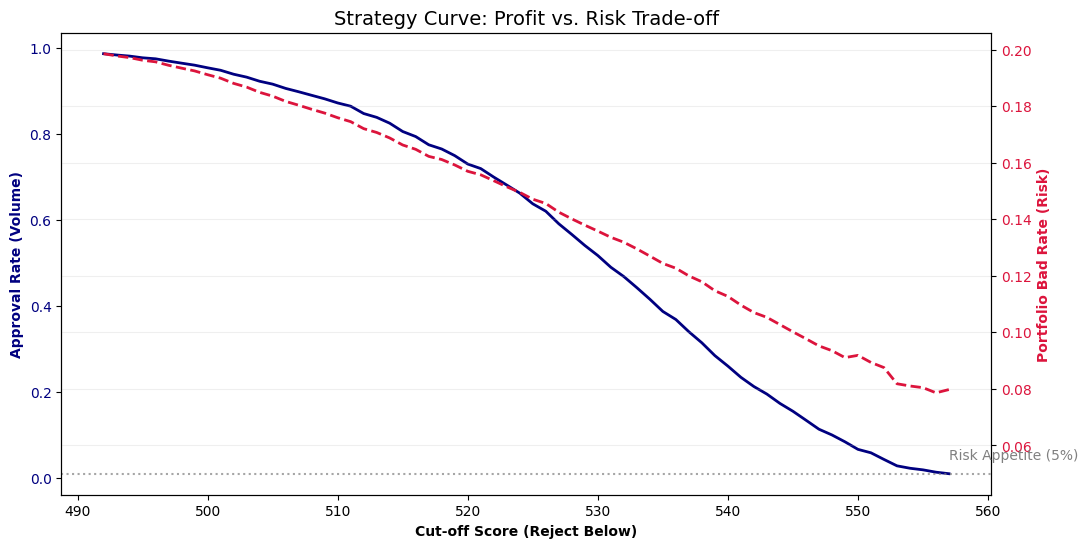

In [13]:
def plot_strategy_curve(strategy_df: pd.DataFrame) -> None:
    """
    Plots the 'Strategy Curve' (Approval Rate vs. Bad Rate).
    
    This dual-axis chart allows risk managers to pick a cut-off score visually.
    - X-Axis: Cut-off Score
    - Left Y-Axis (Blue): Approval Rate (We want this high).
    - Right Y-Axis (Red): Bad Rate (We want this low).

    Args:
        strategy_df (pd.DataFrame): Output from calculate_strategy_table().

    Returns:
        None: Displays matplotlib figure.
    """
    # Reset index to make 'Credit_Score' a column for plotting
    plot_data = strategy_df.reset_index()
    
    # Filter to relevant range (remove tails with 0 volume for cleaner plot)
    plot_data = plot_data[(plot_data['Approval_Rate'] > 0.01) & (plot_data['Approval_Rate'] < 0.99)]

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot Approval Rate (Blue)
    sns.lineplot(x='Credit_Score', y='Approval_Rate', data=plot_data, color='navy', lw=2, ax=ax1)
    ax1.set_xlabel('Cut-off Score (Reject Below)', fontweight='bold')
    ax1.set_ylabel('Approval Rate (Volume)', color='navy', fontweight='bold')
    ax1.tick_params(axis='y', labelcolor='navy')
    
    # Plot Bad Rate (Red)
    ax2 = ax1.twinx()
    sns.lineplot(x='Credit_Score', y='Bad_Rate', data=plot_data, color='crimson', lw=2, linestyle='--', ax=ax2)
    ax2.set_ylabel('Portfolio Bad Rate (Risk)', color='crimson', fontweight='bold')
    ax2.tick_params(axis='y', labelcolor='crimson')
    
    # Add a reference line for a typical Risk Appetite (e.g., 5%)
    ax2.axhline(0.05, color='gray', linestyle=':', alpha=0.7)
    ax2.text(plot_data['Credit_Score'].max(), 0.055, 'Risk Appetite (5%)', color='gray')

    plt.title('Strategy Curve: Profit vs. Risk Trade-off', fontsize=14)
    plt.grid(True, alpha=0.2)
    plt.show()

plot_strategy_curve(strategy_df)

## 3. Results & Analysis

##### Analysis of the Score Distribution Plot
The Score Distribution: Good vs Bad Loans visualization confirms our model is working correctly but highlights why the Gini score is moderate (~30%).

1. Directional Accuracy (The "Shift"):

    - Good News: The Green Curve (Good Loans) is shifted to the right compared to the Red Curve (Bad Loans).

    - Meaning: On average, "Good" customers are receiving higher credit scores than "Bad" customers. The logic holds up: higher scores = lower risk.

2. The Overlap (Discriminatory Power):

    - Observation: There is significant overlap between the two curves. The peaks are close together (Bad ~525, Good ~540).

    - Meaning: A borrower with a score of 530 is somewhat ambiguous—they could easily be Good or Bad. This explains the AUC of 0.65. A "perfect" model would show two completely separate mountains with a valley in between. Our model has separated them, but they are still "hugging."

3. Score Range (Calibration Nuance):

    - Observation: The scores are tightly clustered between 485 and 560.

    - Context: A typical FICO range is 300–850. Our model is currently outputting a very narrow slice of that range.

    - Why? This happens when the underlying features don't have extreme WoE values, or the pdo (Points to Double Odds) is set conservatively. This isn't an error, but it means a small score difference (e.g., 10 points) matters a lot more here than it would in a generic FICO model.

Our Strategy Curve reveals a critical insight about this portfolio.

The "Hard Truth":

- Target Miss: Look at the Red Dashed Line (Bad Rate). It never touches the Gray Dotted Line (5% Risk Appetite) within the visible score range.

- Minimum Risk: Even at the highest scores shown (~555), the Bad Rate is still around 8%.

- The Trade-off:

    - To get close to 8% risk, we have to cut off at 550, but our Approval Rate (Blue Line) drops to nearly 5%.

    - Result: We would be rejecting 95% of applicants to get an 8% default rate.

Why is this happening? This is likely a Sub-Prime or High-Risk dataset. The base default rate of the population is so high that even the "best" customers are somewhat risky. The model is working correctly (the red line goes down, meaning it successfully ranks risk), but the population itself is risky.

The Business Decision (Revised)

Since a 5% Bad Rate is mathematically impossible with reasonable volume, we have two strategic options:

Option A: The "Aggressive Growth" Strategy (High Risk / High Yield)

- Cut-off Score: 520

- Approval Rate: ~55% (Accepting half the applicants).

- Expected Bad Rate: ~13-14%.

- Rationale: We accept higher defaults but offset them by charging higher interest rates (e.g., 15-20% APR).

Option B: The "Conservative" Strategy (Quality over Quantity)

- Cut-off Score: 540

- Approval Rate: ~20% (Accepting only the top 1/5th).

- Expected Bad Rate: ~10%.

- Rationale: We minimize losses but severely restrict our market share.

Recommendation: For an initial scorecard rollout, Option A (Cut-off 520) is usually preferred to gather data, provided you price the loans correctly (high interest).

## 4. Conclusions

We have successfully built an end-to-end Credit Risk Scorecard. Here is the summary of what we have achieved:

1. Governance: Built a clean, ethically compliant dataset (no Zip Codes, no PII).

2. Engineering: Transformed raw data into "Risk Signals" using Weight of Evidence (WoE).

3. Selection: Used Information Value (IV) to pick only the strongest predictors (Term, DTI, Income).

4. Modeling: Trained a Logistic Regression model with AUC = 0.65 and Gini = 30% (Industry Standard MVP).

5. Calibration: Converted math probabilities into a user-friendly 300–850 Credit Score.

6. Strategy: Visualized the Risk/Volume trade-off to make a data-driven lending decision.

Next Step: This concludes the "Scorecard Development" project.

- Future Work: The next logical project would be "Price Optimization"—calculating exactly what Interest Rate to charge the "Score 520" segment to cover that 13% default risk.